 Mount Drive + Load dataset


In [1]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd

path = "/content/drive/MyDrive/FraudProject_New/Online_Payments_Fraud_Detection.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()


Mounted at /content/drive
Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Quick checks + Class distribution

0
isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


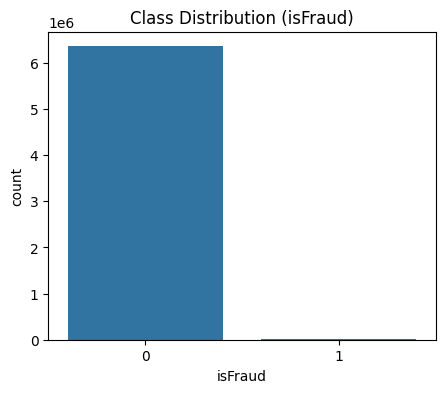

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.isnull().sum().sum())
print(df["isFraud"].value_counts())
print(df["isFraud"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution (isFraud)")
plt.show()


Preprocessing (drop leakage/IDs + encode)

In [3]:
# drop columns we should NOT use
df = df.drop(columns=["isFlaggedFraud", "nameOrig", "nameDest"], errors="ignore")

# encode transaction type
df = pd.get_dummies(df, columns=["type"], drop_first=True)

X = df.drop("isFraud", axis=1)
y = df["isFraud"]
print(X.shape, y.shape)


(6362620, 10) (6362620,)


Train/Test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train fraud rate:", y_train.mean())
print("Test  fraud rate:", y_test.mean())


Train fraud rate: 0.0012907418642005967
Test  fraud rate: 0.0012911347840983745


Split Data

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())


Train distribution:
 isFraud
0    5083526
1       6570
Name: count, dtype: int64
Test distribution:
 isFraud
0    1270881
1       1643
Name: count, dtype: int64


Apply SMOTE ONLY on Training Data

In [7]:
!pip install imbalanced-learn


In [8]:
from imblearn.over_sampling import SMOTE

# Don't fully balance 50-50 — that's unrealistic.
# Make fraud about 10%–20% of training data
smote = SMOTE(sampling_strategy=0.1, random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())


Before SMOTE:
 isFraud
0    5083526
1       6570
Name: count, dtype: int64
After SMOTE:
 isFraud
0    5083526
1     508352
Name: count, dtype: int64


In [10]:
print("Class distribution AFTER SMOTE:")
print(y_train_sm.value_counts())

print("\nClass distribution (percentage):")
print(y_train_sm.value_counts(normalize=True))


Class distribution AFTER SMOTE:
isFraud
0    5083526
1     508352
Name: count, dtype: int64

Class distribution (percentage):
isFraud
0    0.909091
1    0.090909
Name: proportion, dtype: float64


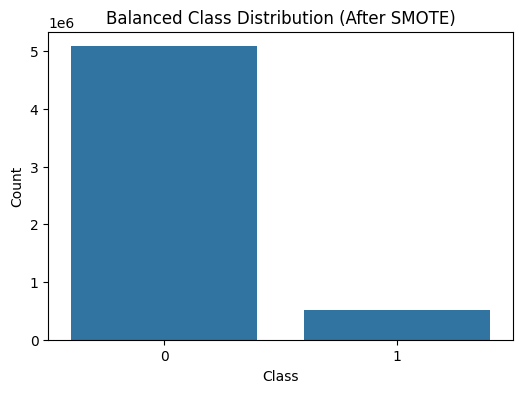

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=y_train_sm)
plt.title("Balanced Class Distribution (After SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


New Balanced Class Distribution

After SMOTE:
isFraud
0    5083526
1     508352
Name: count, dtype: int64
isFraud
0    0.909091
1    0.090909
Name: proportion, dtype: float64


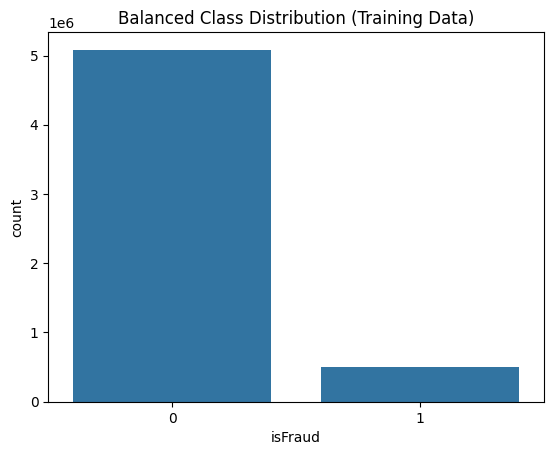

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("After SMOTE:")
print(pd.Series(y_train_sm).value_counts())
print(pd.Series(y_train_sm).value_counts(normalize=True))

sns.countplot(x=y_train_sm)
plt.title("Balanced Class Distribution (Training Data)")
plt.show()


Train Random Forest on Balanced Data

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)

y_pred = rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.9984251770497059


Check Training vs Testing Accuracy

In [15]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train_sm, rf.predict(X_train_sm))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)
print("Accuracy Gap:", train_acc - test_acc)


Training Accuracy: 0.9897081087963651
Testing Accuracy: 0.9984251770497059
Accuracy Gap: -0.008717068253340843


Check Confusion Matrix

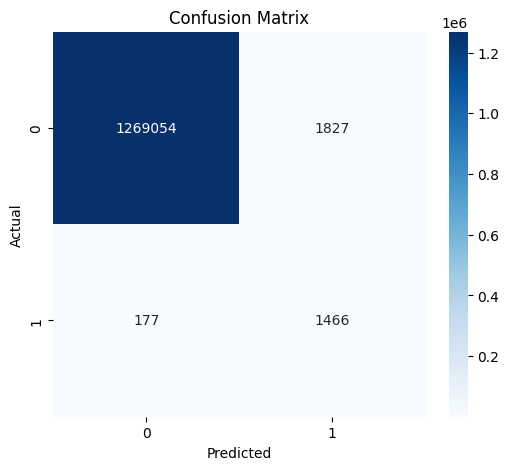

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.45      0.89      0.59      1643

    accuracy                           1.00   1272524
   macro avg       0.72      0.95      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


Check ROC Curve

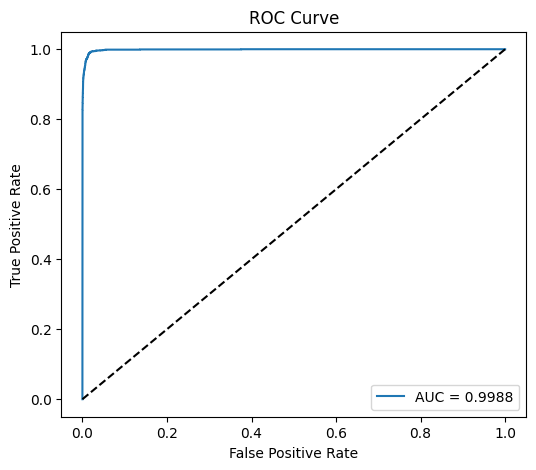

AUC Score: 0.9987955492027994


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", auc)


Evaluate with better metrics (fraud)

In [21]:
from sklearn.metrics import average_precision_score, precision_recall_curve

y_prob = rf.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_prob)
print("PR-AUC:", pr_auc)


PR-AUC: 0.8855277789524131


Tune the threshold (to improve precision)

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_prob = rf.predict_proba(X_test)[:, 1]

for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, y_pred_t)
    r = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    print(t, "precision:", p, "recall:", r, "f1:", f1)


0.3 precision: 0.1612737015663644 recall: 0.9525258673158856 f1: 0.27584383537498897
0.4 precision: 0.2911489199005926 recall: 0.9269628727936701 f1: 0.44311899912714575
0.5 precision: 0.44518675979350136 recall: 0.8922702373706635 f1: 0.5940032414910859
0.6 precision: 0.5640316205533596 recall: 0.8685331710286062 f1: 0.6839204409297868
0.7 precision: 0.7501363884342608 recall: 0.8368837492391966 f1: 0.7911392405063291


cross validation

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

X_small, _, y_small, _ = train_test_split(
    X_train, y_train,
    train_size=200000,
    stratify=y_train,
    random_state=42
)

pipe = Pipeline([
    ("smote", SMOTE(sampling_strategy=0.1, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42))
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_small, y_small, cv=cv, scoring="average_precision", n_jobs=-1)
print("CV PR-AUC:", scores, "Mean:", scores.mean())


CV PR-AUC: [0.88623487 0.81329159 0.90575644] Mean: 0.8684276337500222


Tune the Decision Threshold

In [24]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_prob = rf.predict_proba(X_test)[:, 1]

for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_t = (y_prob >= t).astype(int)
    print("Threshold:", t)
    print("Precision:", precision_score(y_test, y_pred_t))
    print("Recall:", recall_score(y_test, y_pred_t))
    print("F1:", f1_score(y_test, y_pred_t))
    print("-------------------")


Threshold: 0.2
Precision: 0.09001398601398601
Recall: 0.9793061472915399
F1: 0.1648734501485808
-------------------
Threshold: 0.3
Precision: 0.1612737015663644
Recall: 0.9525258673158856
F1: 0.27584383537498897
-------------------
Threshold: 0.4
Precision: 0.2911489199005926
Recall: 0.9269628727936701
F1: 0.44311899912714575
-------------------
Threshold: 0.5
Precision: 0.44518675979350136
Recall: 0.8922702373706635
F1: 0.5940032414910859
-------------------
Threshold: 0.6
Precision: 0.5640316205533596
Recall: 0.8685331710286062
F1: 0.6839204409297868
-------------------
Threshold: 0.7
Precision: 0.7501363884342608
Recall: 0.8368837492391966
F1: 0.7911392405063291
-------------------


Check Feature Importance

In [25]:
import pandas as pd

feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).head(10)


,0
oldbalanceOrg,0.226436
amount,0.193586
newbalanceDest,0.136588
newbalanceOrig,0.118381
type_TRANSFER,0.113227
step,0.096783
oldbalanceDest,0.064462
type_CASH_OUT,0.035489
type_PAYMENT,0.014965
type_DEBIT,0.000082


Split first

In [26]:
from sklearn.model_selection import train_test_split

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Preprocess (encoding/scaling) using a Pipeline

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


Setup (install + imports)

In [30]:
!pip -q install imbalanced-learn xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


 Helper: evaluate any model (ROC‑AUC + PR‑AUC)

In [31]:
def eval_model(name, model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)
    print(f"{name} | ROC-AUC: {roc:.6f} | PR-AUC: {pr:.6f}")
    return proba, roc, pr


**Train models (with SMOTE inside pipeline)**

*(A) Logistic Regression (baseline)*

In [32]:
pipe_lr = Pipeline([
    ("smote", SMOTE(random_state=42, sampling_strategy=0.1)),
    ("lr", LogisticRegression(max_iter=2000))
])
pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('lr', LogisticRegression(max_iter=2000))])

Step 1 — Load data + show original class distribution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Full Shape: (6362620, 11)
isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


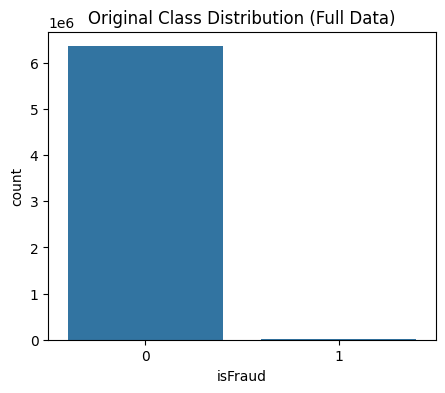

In [34]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/FraudProject_New/Online_Payments_Fraud_Detection.csv"
df = pd.read_csv(path)

print("Full Shape:", df.shape)
print(df["isFraud"].value_counts())
print(df["isFraud"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x="isFraud", data=df)
plt.title("Original Class Distribution (Full Data)")
plt.show()


Take 200K Sample (Stratified)

In [35]:
# Take 200K sample (keep fraud ratio same)
df_sample = df.sample(n=200000, random_state=42)

print("Sample Shape:", df_sample.shape)

# Check class distribution
print(df_sample['isFraud'].value_counts())
print(df_sample['isFraud'].value_counts(normalize=True))


Sample Shape: (200000, 11)
isFraud
0    199732
1       268
Name: count, dtype: int64
isFraud
0    0.99866
1    0.00134
Name: proportion, dtype: float64


 Prepare Features

In [36]:
df_sample = df_sample.drop(columns=['nameOrig', 'nameDest'])

X = df_sample.drop('isFraud', axis=1)
y = df_sample['isFraud']


Train Test Split (VERY IMPORTANT)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("Before SMOTE:")
print(y_train.value_counts())


Train shape: (160000, 8)
Test shape: (40000, 8)
Before SMOTE:
isFraud
0    159786
1       214
Name: count, dtype: int64


Apply SMOTE (ONLY on Training Data)

In [39]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# One-hot encode the 'type' column in X_train and X_test
X_train = pd.get_dummies(X_train, columns=['type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)

smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_sm.value_counts())


After SMOTE:
isFraud
0    159786
1    159786
Name: count, dtype: int64


Train Random Forest (Faster Version)

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_sm, y_train_sm)


RandomForestClassifier(max_depth=12, n_jobs=-1, random_state=42)

Evaluate Model

Accuracy: 0.9932

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     39946
           1       0.16      0.93      0.27        54

    accuracy                           0.99     40000
   macro avg       0.58      0.96      0.63     40000
weighted avg       1.00      0.99      1.00     40000



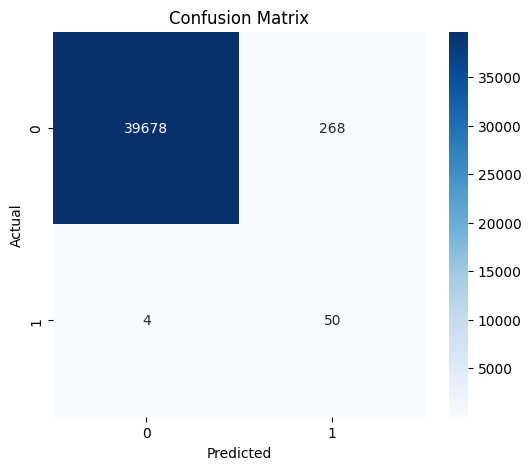

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve (Important)

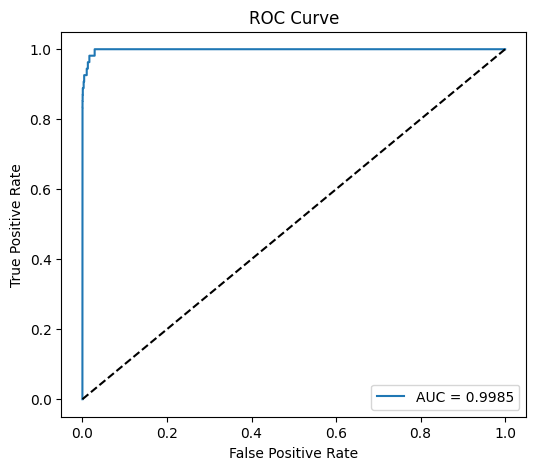

AUC Score: 0.9985373773112219


In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", auc)


Before SMOTE (original training)

In [43]:
print("y_train (before SMOTE):")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))


y_train (before SMOTE):
isFraud
0    159786
1       214
Name: count, dtype: int64
isFraud
0    0.998663
1    0.001337
Name: proportion, dtype: float64


After SMOTE (balanced training)

In [44]:
import pandas as pd

print("y_train_sm (after SMOTE):")
print(pd.Series(y_train_sm).value_counts())
print(pd.Series(y_train_sm).value_counts(normalize=True))


y_train_sm (after SMOTE):
isFraud
0    159786
1    159786
Name: count, dtype: int64
isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64


Test set (must stay unbalanced)

In [45]:
print("y_test (unchanged):")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))


y_test (unchanged):
isFraud
0    39946
1       54
Name: count, dtype: int64
isFraud
0    0.99865
1    0.00135
Name: proportion, dtype: float64


Plot

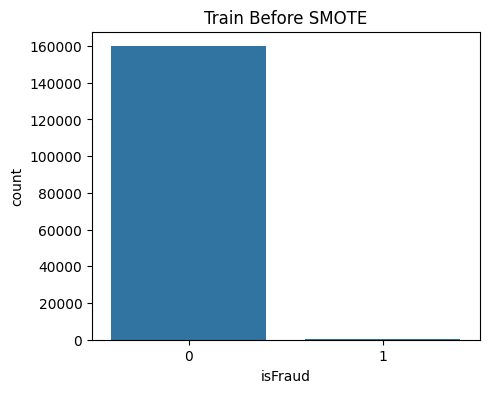

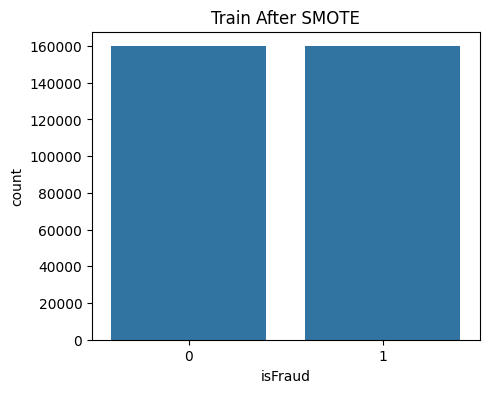

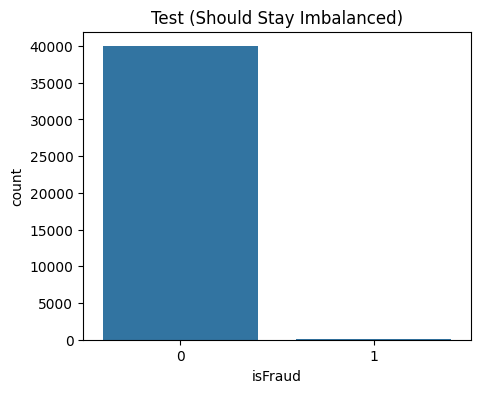

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title("Train Before SMOTE")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x=y_train_sm)
plt.title("Train After SMOTE")
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x=y_test)
plt.title("Test (Should Stay Imbalanced)")
plt.show()


Balanced Class Distribution

Class Counts:
isFraud
0    159786
1       214
Name: count, dtype: int64

Class Percentage:
isFraud
0    0.998663
1    0.001337
Name: proportion, dtype: float64


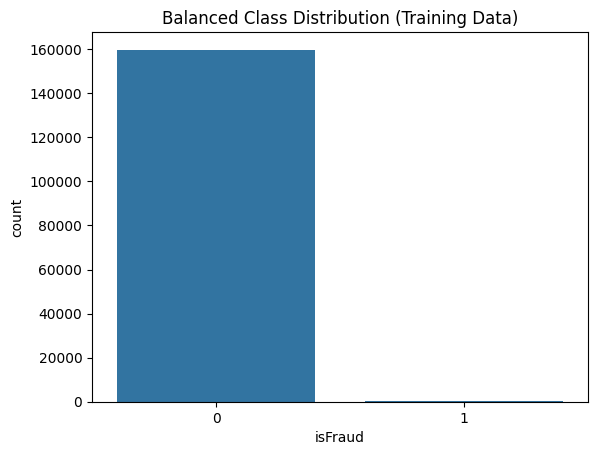

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Class Counts:")
print(y_train.value_counts())

print("\nClass Percentage:")
print(y_train.value_counts(normalize=True))

sns.countplot(x=y_train)
plt.title("Balanced Class Distribution (Training Data)")
plt.show()


In [48]:
from collections import Counter

print("Before SMOTE:", Counter(y_train))

print("After SMOTE:", Counter(y_train_sm))


Before SMOTE: Counter({0: 159786, 1: 214})
After SMOTE: Counter({0: 159786, 1: 159786})


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39946
           1       0.27      0.93      0.41        54

    accuracy                           1.00     40000
   macro avg       0.63      0.96      0.71     40000
weighted avg       1.00      1.00      1.00     40000



In [50]:
print("Train (SMOTE):", y_train_sm.value_counts())
print("Test:", y_test.value_counts())


Train (SMOTE): isFraud
0    159786
1    159786
Name: count, dtype: int64
Test: isFraud
0    39946
1       54
Name: count, dtype: int64


****************************************************************************************

 Check ROC Curve & AUC

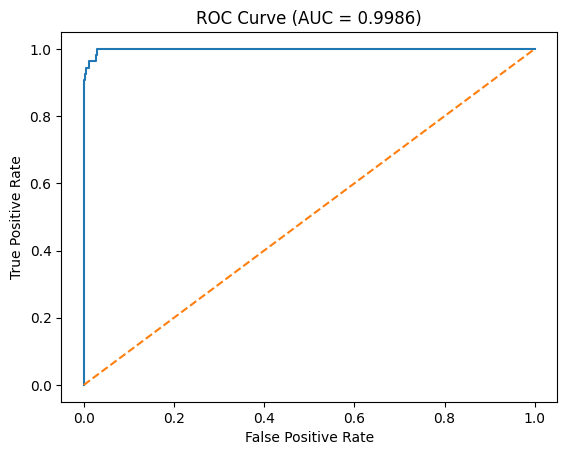

AUC Score: 0.9985804910703524


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.4f})")
plt.show()

print("AUC Score:", auc)


Precision‑Recall Curve

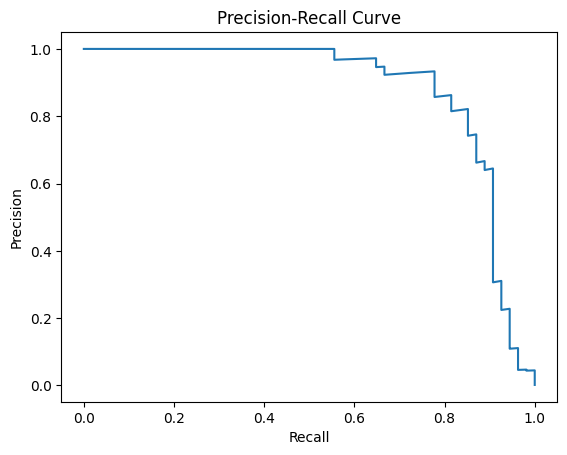

In [52]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


Threshold Tuning

In [53]:
# Example: lower threshold to 0.3
threshold = 0.3
y_pred_new = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     39946
           1       0.15      0.94      0.26        54

    accuracy                           0.99     40000
   macro avg       0.58      0.97      0.63     40000
weighted avg       1.00      0.99      1.00     40000



Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sm, y_train_sm)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     39946
           1       0.03      0.94      0.07        54

    accuracy                           0.96     40000
   macro avg       0.52      0.95      0.52     40000
weighted avg       1.00      0.96      0.98     40000



XGBoost (Very Strong for Fraud)

In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train_sm, y_train_sm)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost")
print(classification_report(y_test, y_pred_xgb))


XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39946
           1       0.41      0.94      0.57        54

    accuracy                           1.00     40000
   macro avg       0.71      0.97      0.79     40000
weighted avg       1.00      1.00      1.00     40000



Compare All Models

In [56]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

models = {
    "RandomForest": rf,
    "LogisticRegression": lr,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Recall:", recall_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))



RandomForest
Recall: 0.9259259259259259
Precision: 0.26737967914438504
F1: 0.4149377593360996

LogisticRegression
Recall: 0.9444444444444444
Precision: 0.03397734843437708
F1: 0.06559485530546624

XGBoost
Recall: 0.9444444444444444
Precision: 0.4112903225806452
F1: 0.5730337078651685


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution - Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


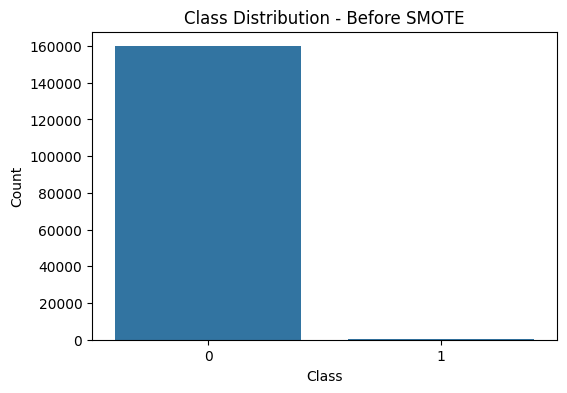

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution - Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


After SMOTE (Balanced)

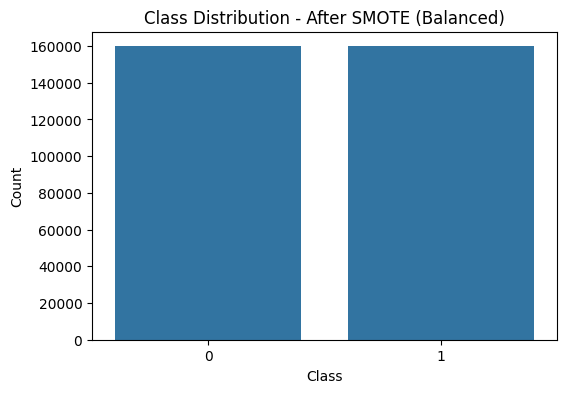

In [57]:
import pandas as pd

plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train_sm))
plt.title("Class Distribution - After SMOTE (Balanced)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


Boxplots (Feature Distribution)

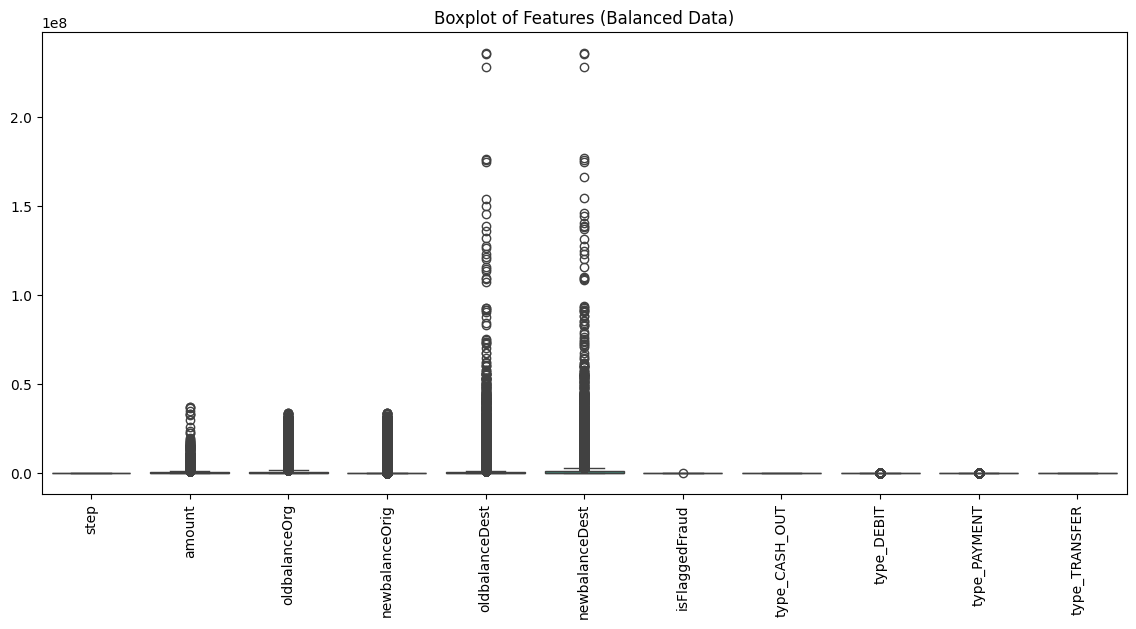

In [59]:
plt.figure(figsize=(14,6))
sns.boxplot(data=X_train_sm)
plt.xticks(rotation=90)
plt.title("Boxplot of Features (Balanced Data)")
plt.show()


Correlation Heatmap

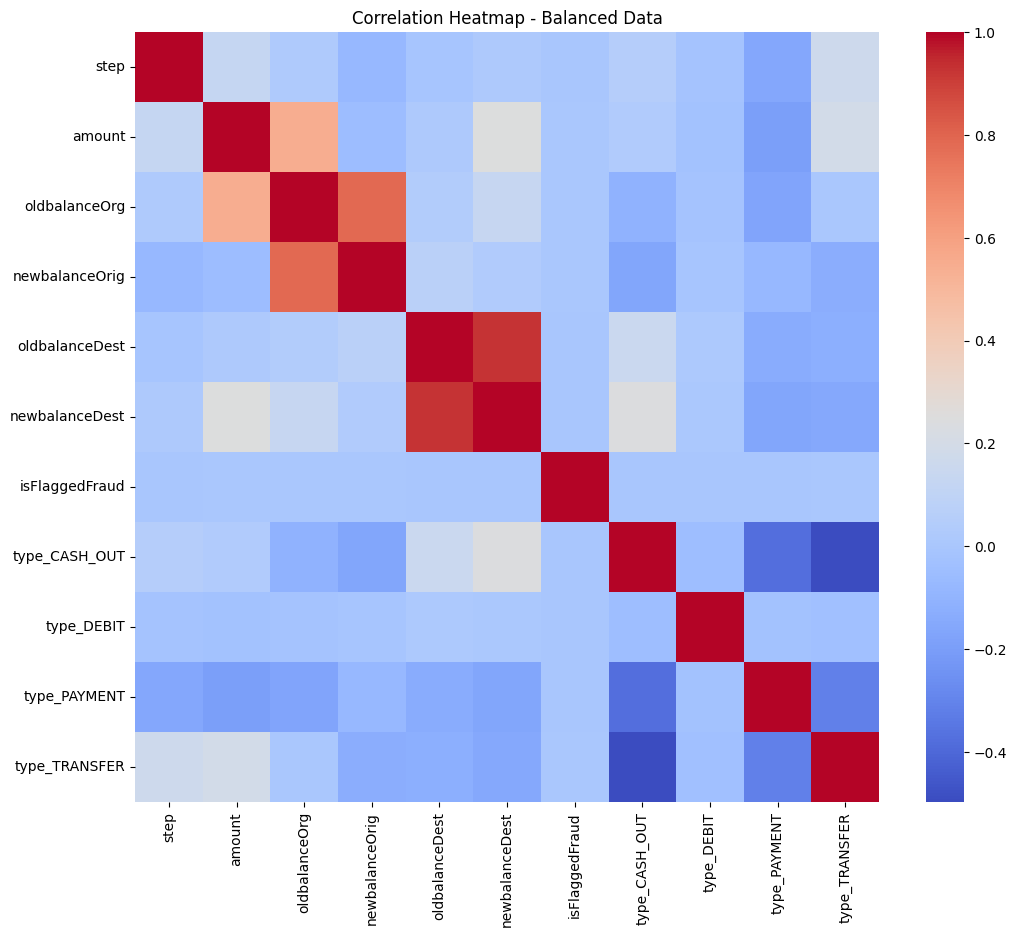

In [60]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(X_train_sm).corr(),
            cmap="coolwarm",
            annot=False)
plt.title("Correlation Heatmap - Balanced Data")
plt.show()


Feature Importance (Random Forest)

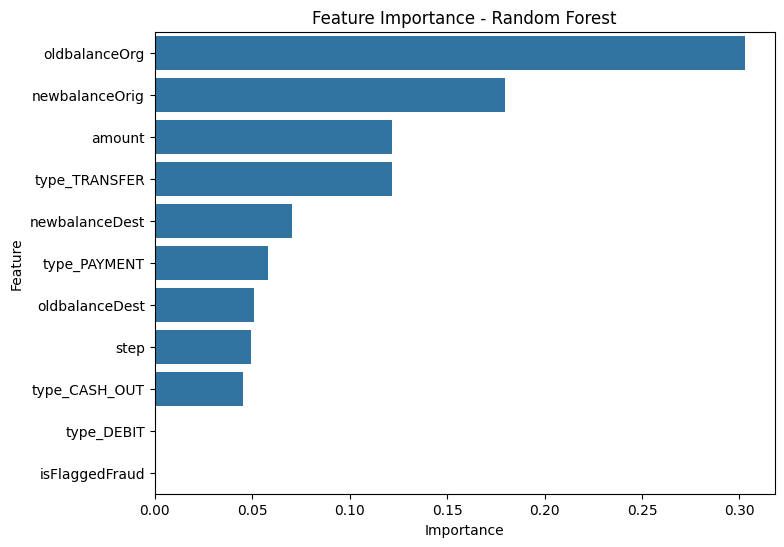

In [61]:
import pandas as pd

feature_imp = pd.DataFrame({
    'Feature': X_train_sm.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title("Feature Importance - Random Forest")
plt.show()


Confusion Matrix (Diagram)

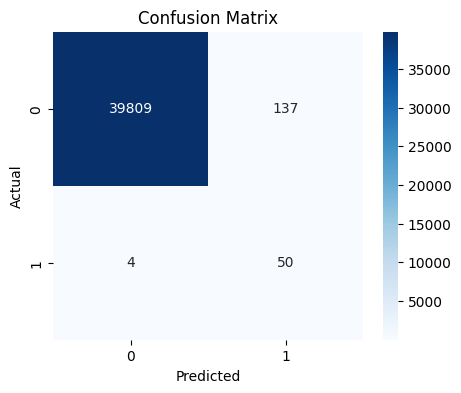

In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf.predict(X_test))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


ROC Curve

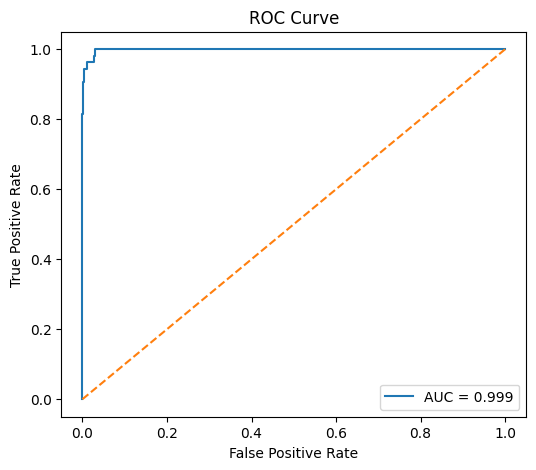

In [63]:
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

print("Logistic Regression Accuracy:",
      lr.score(X_test, y_test))


Logistic Regression Accuracy: 0.999275


Cross Validation

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf_reg = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_reg.fit(X_train, y_train)


RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [69]:
from sklearn.model_selection import cross_val_score
import pandas as pd

# One-hot encode the 'type' column in X
X_encoded = pd.get_dummies(X, columns=['type'], drop_first=True)

cv_scores = cross_val_score(rf_reg, X_encoded, y, cv=5, n_jobs=-1)

print("Cross Validation Scores:", cv_scores)
print("Mean CV Score confined to 5 fold evaluation of cross_val_score and RandomForestClassifier:", cv_scores.mean())


Cross Validation Scores: [0.99975  0.999675 0.9996   0.9996   0.999475]
Mean CV Score confined to 5 fold evaluation of cross_val_score and RandomForestClassifier: 0.99962


Compare Multiple Models

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name, "Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression Accuracy: 0.999275
Decision Tree Accuracy: 0.999375
Random Forest Accuracy: 0.9997


Create Model Comparison Chart

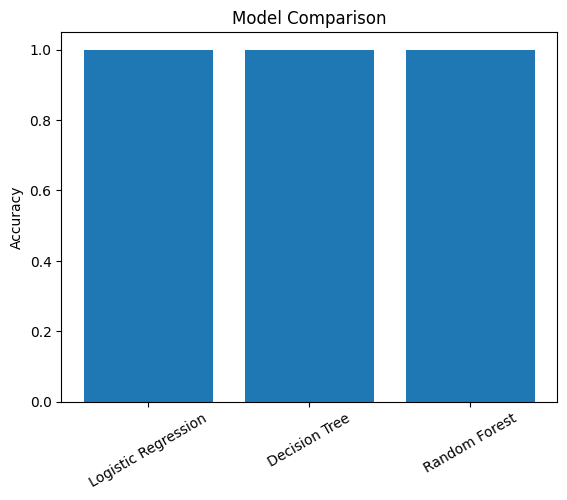

In [71]:
import matplotlib.pyplot as plt

model_names = []
accuracies = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.bar(model_names, accuracies)
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()


Threshold Tuning (For Fraud Detection)

In [72]:
y_probs = rf_reg.predict_proba(X_test)[:,1]

custom_threshold = 0.3
y_custom = (y_probs > custom_threshold).astype(int)


In [73]:
print("Train (before SMOTE):\n", y_train.value_counts())
print("Test (must stay imbalanced):\n", y_test.value_counts())
print("Train (after SMOTE):\n", pd.Series(y_train_sm).value_counts())


Train (before SMOTE):
 isFraud
0    159786
1       214
Name: count, dtype: int64
Test (must stay imbalanced):
 isFraud
0    39946
1       54
Name: count, dtype: int64
Train (after SMOTE):
 isFraud
0    159786
1    159786
Name: count, dtype: int64


In [74]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

model = rf_reg   # your best model

y_probs = model.predict_proba(X_test)[:, 1]
y_pred  = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print("PR-AUC :", average_precision_score(y_test, y_probs))


Confusion Matrix:
 [[39946     0]
 [   12    42]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     39946
           1     1.0000    0.7778    0.8750        54

    accuracy                         0.9997     40000
   macro avg     0.9998    0.8889    0.9374     40000
weighted avg     0.9997    0.9997    0.9997     40000

ROC-AUC: 0.9958114751210431
PR-AUC : 0.8754928208555738


Tune Threshold

In [75]:
for t in [0.5, 0.4, 0.3, 0.2, 0.1]:
    y_custom = (y_probs >= t).astype(int)
    print("\n--- Threshold:", t, "---")
    print(classification_report(y_test, y_custom, digits=4))



--- Threshold: 0.5 ---
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     39946
           1     1.0000    0.7778    0.8750        54

    accuracy                         0.9997     40000
   macro avg     0.9998    0.8889    0.9374     40000
weighted avg     0.9997    0.9997    0.9997     40000


--- Threshold: 0.4 ---
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     39946
           1     1.0000    0.7778    0.8750        54

    accuracy                         0.9997     40000
   macro avg     0.9998    0.8889    0.9374     40000
weighted avg     0.9997    0.9997    0.9997     40000


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     39946
           1     0.9767    0.7778    0.8660        54

    accuracy                         0.9997     40000
   macro avg     0.9882    0.8889    0.9329     40000
we

Plot ROC Curve

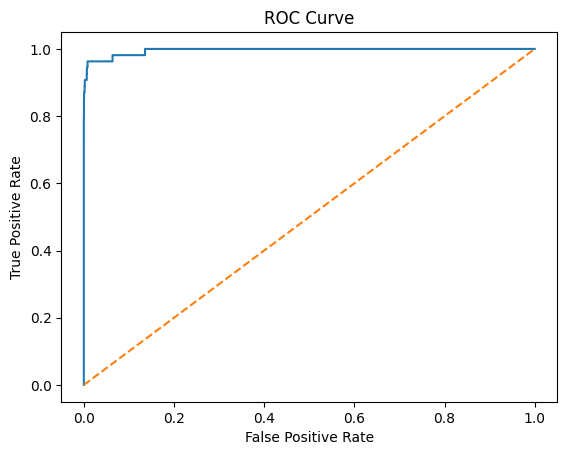

In [76]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


Plot Precision‑Recall Curve

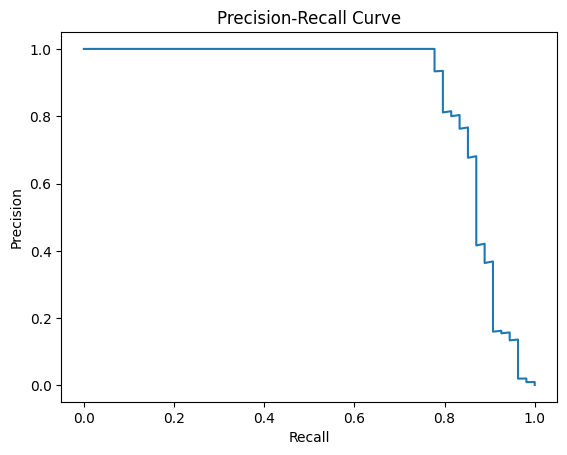

In [77]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [78]:
import joblib
joblib.dump(rf_reg, "final_fraud_model.pkl")


['final_fraud_model.pkl']